In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="ticks", palette="husl", color_codes=True)

from astropy.io import fits

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")



In [2]:
from pyHIIExplorer.HIIblob import *
import time

In [136]:
from pyFIT3D.common.io import get_wave_from_header


# paths
inp_path = "../../_fitting-data/IC342/obs/"
pointing = "manga-9675-12705"
pointing = "manga-12050-12705"
pointing = "manga-12050-12703"
pointing = "manga-9673-9101"
cube_path = os.path.join(inp_path, f"{pointing}.cube.fits.gz")
cube__wyx, cube_header = fits.getdata(cube_path, header=True)
wave__w = get_wave_from_header(cube_header, 3)
clean_mask = (cube__wyx==0).all(axis=0)

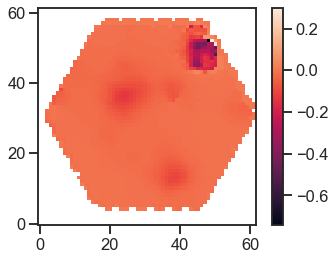

In [137]:
# V-image: collapse all wavelengths
mask_v = (3800<=wave__w)&(wave__w<=9500)
v_image = np.ma.masked_array(cube__wyx[mask_v].mean(axis=0), mask=clean_mask)
# Halpha: 4500-6000
mask_ha = (6463<=wave__w)&(wave__w<=6663)
ha_image = np.ma.masked_array(cube__wyx[mask_ha].mean(axis=0), mask=clean_mask)
# ha_image = np.ma.masked_array(cube__wyx[np.argmin(np.abs(wave__w-6563))], mask=clean_mask)

plt.imshow(v_image-ha_image, origin="lower")
plt.colorbar()

0.1588347902203895
# 1sig Ha-map =  0.0001201001 ; 1sig MUSE-V  0.0
no diffuse points
no diffuse points
# HII reg. Initial =  6
no diffuse points
no diffuse points
no diffuse points
# HII reg. 2nd =  5
no diffuse points
no diffuse points
no diffuse points
# HII reg. additional =  1
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
# Last iteration Num. =  5
no diffuse points
no diffuse points
no diffuse points
# Clean above 3sigma Num =  5
no diffuse points
no diffuse points
no diffuse points
# X_sqr =  301392.79680178274
# HII reg clean= 5
detected stars: 5


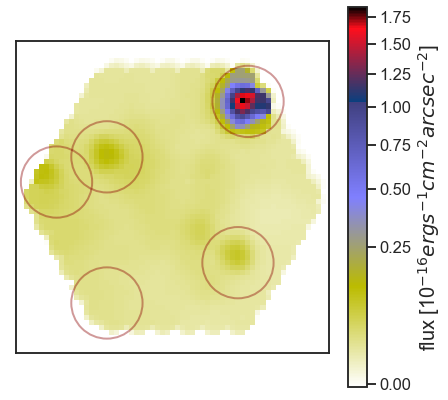

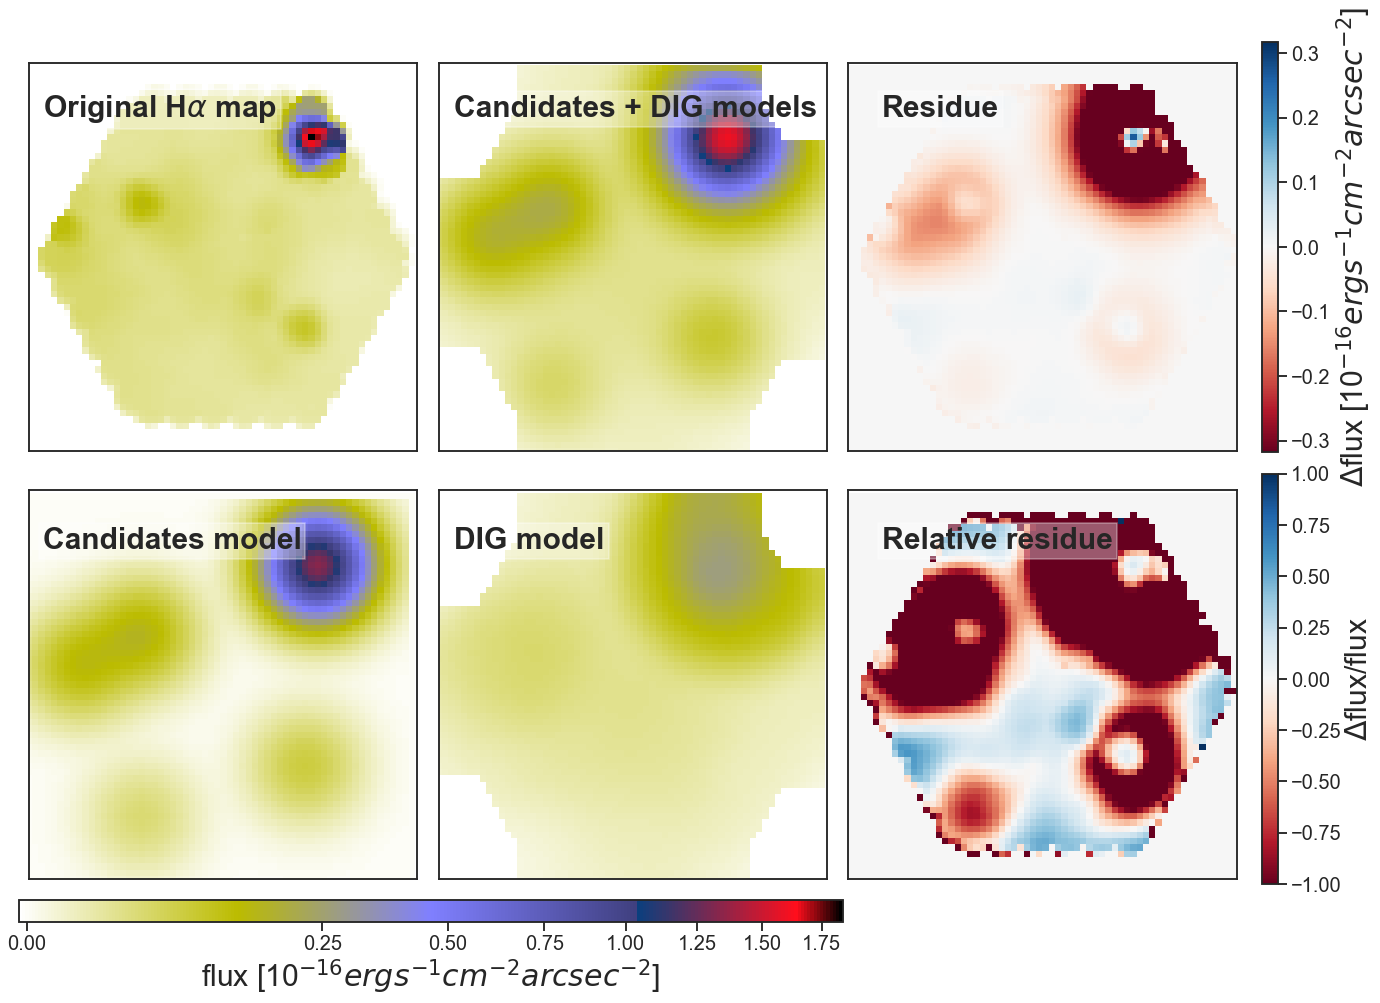

In [139]:
std_v = np.ma.std(v_image)
print(std_v)

blobs_final,blobs_F_Ha,image_HII,diff_map_final,diff_points,diff_Flux=HIIblob(v_image, ha_image, 2.5/0.5, MUSE_1sig=0, MUSE_1sig_V=0, plot=1, refined=0, min_size=2.5/0.5, max_size=5.)


nstars = blobs_final.shape[0]
print(f"detected stars: {nstars}")


In [140]:
image_HII_cube = np.zeros_like(cube__wyx)
rss_spec = np.zeros((wave__w.size, nstars))
for i in range(wave__w.size):
    ha_image = np.ma.masked_array(cube__wyx[i,:,:], mask=clean_mask)
    rss_spec[i,:],image_HII_cube[i,:,:],diff_map_final,diff_points,diff_Flux=HIIextraction(ha_image,blobs_final,kind=0,we=1,FWHM_MUSE = 2.5/0.5, refined = 0)

no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse points
no diffuse

In [141]:
from pyFIT3D.common.io import array_to_fits


header = {}
header["CRPIX1"] = cube_header["CRPIX3"]
header["CRVAL1"] = cube_header["CRVAL3"]
header["CDELT1"] = cube_header["CDELT3"]

array_to_fits(f"_data/star-mask/CS.{pointing}-stars.RSS.fits.gz", rss_spec.T, header=header, overwrite=True)
array_to_fits(f"_data/star-mask/e_CS.{pointing}-stars.RSS.fits.gz", np.sqrt(np.abs(rss_spec)).T, header=header, overwrite=True)

Text(0, 0.5, '$f_\\lambda/f_{5500}$')

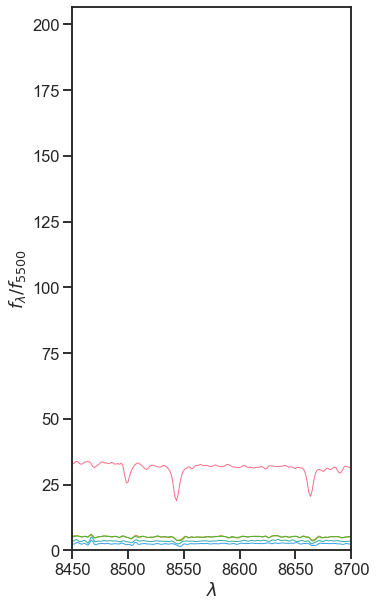

In [142]:
plt.figure(figsize=(5,10))
for i in range(nstars):
    plt.plot(wave__w, rss_spec[:,i], lw=1)
plt.xlim(8450, 8700)
# plt.xlim(3930, 3965)
ylim = plt.gca().get_ylim()
plt.ylim((max(0,ylim[0]),ylim[1]))
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$f_\lambda/f_{5500}$")

In [143]:
from lvmdap._cmdline import dap

obs_path = "../../_fitting-data/IC342/"
# using the initial values:
#
# Instrumental dispersion: 2.5 AA
sigma_inst = 0.001

# Velocity dispersion of the gas in AA
sigma_gas = 3.7

# Masks:
#     File with list of ranges of wavelength to be masked in whole analysis
mask_list = None#'../../_fitting-data/_configs/mask_elines.txt'

######################
######################
# Non linear analysis: (redshift, observed dispersion and dust attenuation)
#     wavelength range: 
#         [3850, 4700] AA for the redshift and sigma analysis
#         [3800, 7000] AA for the dust attenuation
w_min_max = [3800, 9500]
nl_w_min_max = [4700, 6000]

#     models:
#         Miles solar 3 models
ssp_nl_fit_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-5.fits.gz'

#     emission lines to be masked:
elines_mask_file = '../../_fitting-data/_configs/MaNGA/emission_lines_long_list.txt'

#     redshift:
#         initial value: 0.02449
#                 delta: 0.0001
#                   min: 0.02349
#                   max: 0.02549
redshift_set = [0.0000, 0, -0.5, 0.5]

#     dispersion: (km/s)
#         initial value: 30
#                 delta: 20
#                   min: 1
#                   max: 150
sigma_set = [0, 0, 0, 350]

#     dust attenuation at V band (mag):
#         initial value: 0.3
#                 delta: 0.15
#                   min: 0
#                   max: 1.6
AV_set = [0, 0.1, 0, 2.5]

ssp_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-100.fits.gz'

sed_file = os.path.join("_data/star-mask", f"CS.{pointing}-stars.RSS.fits.gz")
err_file = os.path.join("_data/star-mask", f"e_CS.{pointing}-stars.RSS.fits.gz")
label = os.path.basename(sed_file).replace(".RSS.fits.gz","").replace("CS.","")

cmdline = f"{sed_file} {ssp_file} {sigma_inst} {label} --input-fmt rss --error-file {err_file} --rsp-nl-file {ssp_nl_fit_file} --w-range {' '.join(map(str,w_min_max))} --w-range-nl {' '.join(map(str,nl_w_min_max))} --redshift {' '.join(map(str,redshift_set))} --sigma {' '.join(map(str,sigma_set))} --AV {' '.join(map(str,AV_set))} --sigma-gas {sigma_gas} --emission-lines-file {elines_mask_file} -c --single-gas-fit --output-path _data/star-mask".split()

dap._main(cmdline)


# ID 0/4 ===============================================

ipykernel_launcher.py: no mask list file
---[ StPopSynt ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
| Input config: 
| - MIN_DELTA_CHI_SQ = 0.0001
| - MAX_N_ITER = 1
| - CUT_MEDIAN_FLUX = 0.0
| - Wavelength range - [3800.00, 9500.00] - Non-linear analysis: [4700.00, 6000.00]
| - Instrumental dispersion: 0.001
| - Redshift - guess:0.000000 delta:0.000000 min:-0.500000 max:0.500000
| - Sigma    - guess:0.000000 delta:0.000000 min:0.000000 max:350.000000
| - AV       - guess:0.000000 delta:0.100000 min:0.000000 max:2.500000
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| Emission lines analysis:
| - Number of systems = 4
| - wavelength range: 3787-5230 - config file: /disk-a/mejia/Research/UNAM/l

In [144]:
rss_model = fits.open(f"_data/star-mask/output.{label}.fits.gz")
rss_model[0].data.shape

(6, 5, 4487)

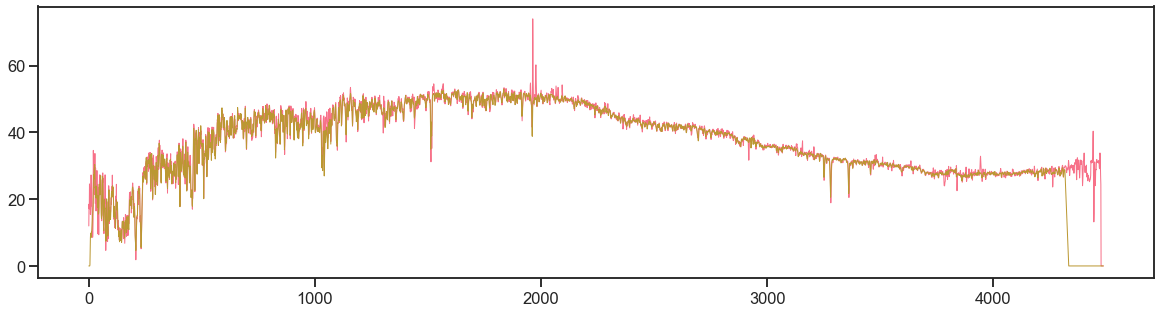

In [145]:
plt.figure(figsize=(20,5))

plt.plot(rss_model[0].data[0,0,:], lw=1)
plt.plot(rss_model[0].data[1,0,:], lw=1)

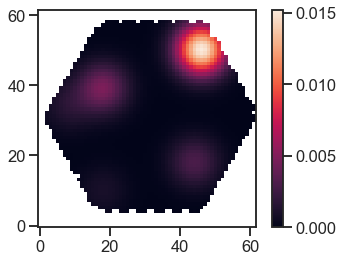

In [149]:
rss_model = fits.open(f"_data/star-mask/output.{label}.fits.gz")


rss_model_spec = rss_model[0].data[1,:,:].T

_, ny, nx = cube__wyx.shape

image_stars_cube = np.zeros_like(cube__wyx)
blobs_final_norm = blobs_final.copy()
blobs_final_norm[:,2] = blobs_final_norm[:,2]/np.sqrt(2)

for i in range(wave__w.size):
    image_stars_cube[i,:,:] = create_HII_image(blobs_final_norm,rss_model_spec[i,:],ny,nx,dr=5)

plt.imshow(np.ma.masked_array((image_HII_cube-image_stars_cube).mean(axis=0), mask=clean_mask), origin="lower")
plt.colorbar()

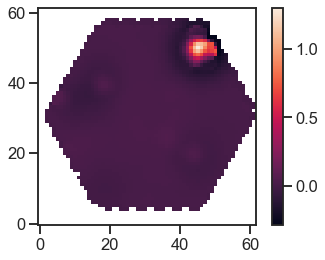

In [148]:
array_to_fits(os.path.join("_data/star-mask", f"{pointing}.BG.fits.gz"), (cube__wyx-image_stars_cube), header=cube_header, overwrite=True)

plt.imshow(np.ma.masked_array((cube__wyx-image_stars_cube).mean(axis=0), mask=clean_mask), origin="lower")
plt.colorbar()